In [41]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import neighbors, linear_model
from sklearn.model_selection import cross_val_predict, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer
from sklearn.preprocessing import PolynomialFeatures

import seaborn as sn
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('data.csv')
song_names = data['song name']
song_names
data = data.drop(columns=['song name'])


<h1>Setting up </h1>

In [13]:
#data2 = data[data.genre != 'westcoastrap']
msfcc_names = []
for i in range(1, 21):
    msfcc_names.append('mfcc{0}'.format(i))
X = data[['zero crossing rate', 'spectral bandwidth', 'spectral centroid', 'chroma'] + msfcc_names]

In [14]:
genre_dict = {'alternative': 0, 'westcoastrap': 1,'edm': 2, 'jazz': 3, 'classical': 4} 
Y = [genre_dict[item] for item in data['genre']]

<h2>KNN-analysis</h2>

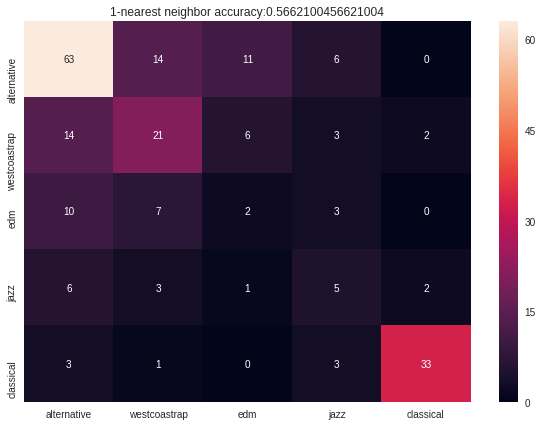

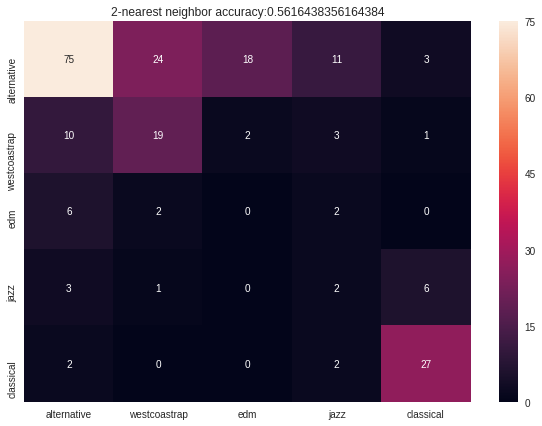

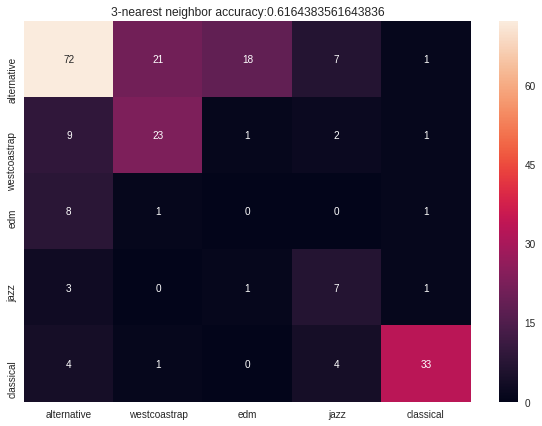

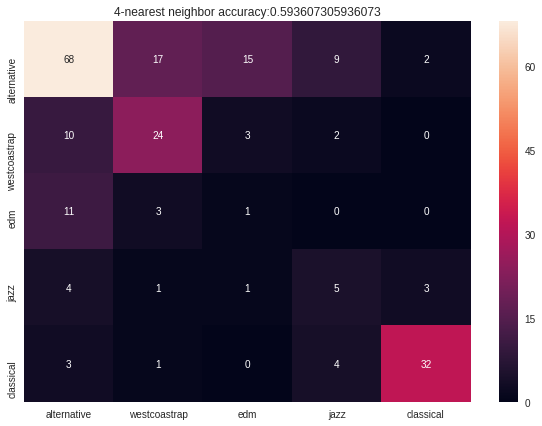

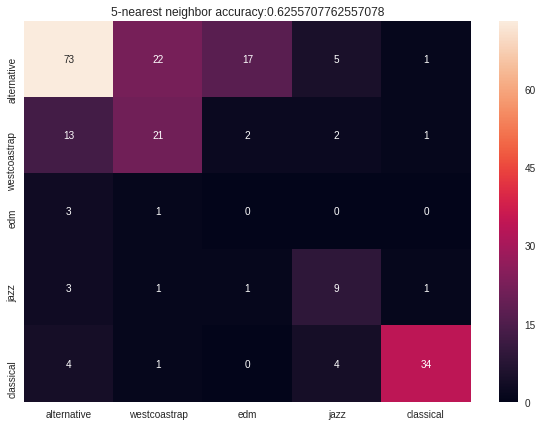

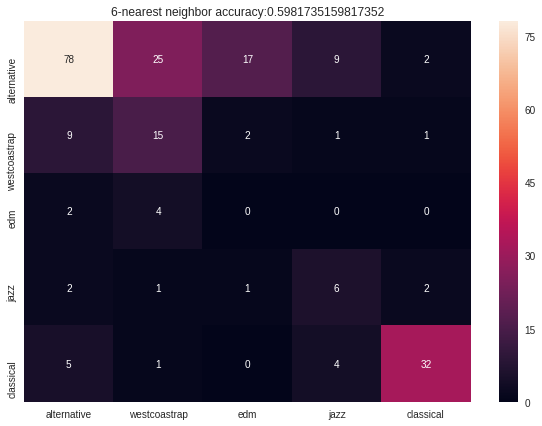

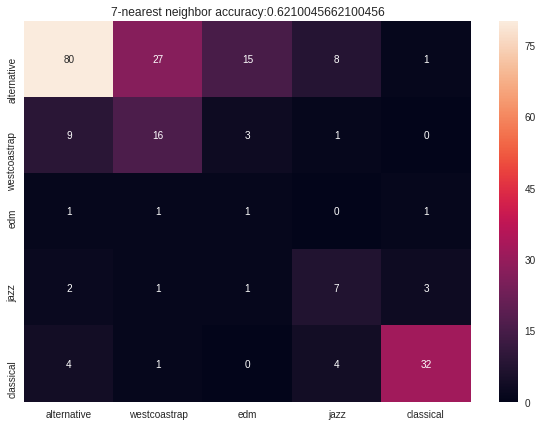

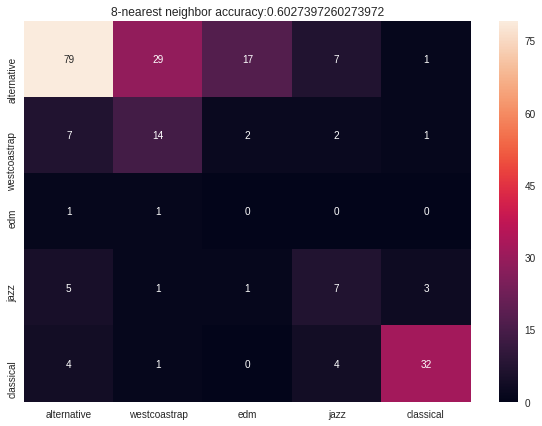

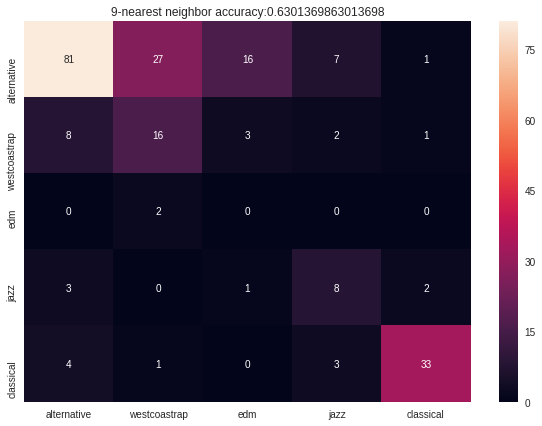

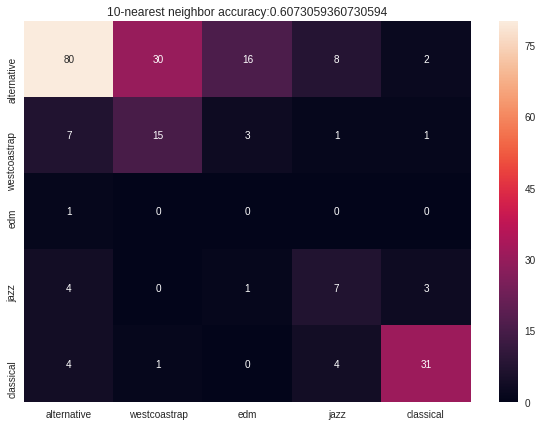

In [38]:
for k in range(1,11):
    model = neighbors.KNeighborsClassifier(k)
    yhat= cross_val_predict(model,X,Y, cv = StratifiedKFold(5, True))
    label_ord = range(5)
    Titanic_Conf_matrix = confusion_matrix(yhat,Y, labels=label_ord)
    #print('{0}-nearest neighbor accuracy:{1}'.format(k, np.trace(Titanic_Conf_matrix)/np.sum(Titanic_Conf_matrix)))
    df_cm = pd.DataFrame(Titanic_Conf_matrix, index = [i for i in ['alternative', 'westcoastrap', 'edm', 'jazz', 'classical']],
                  columns = [i for i in ['alternative', 'westcoastrap', 'edm', 'jazz', 'classical']])
    plt.figure(figsize = (10,7))
    plt.title('{0}-nearest neighbor accuracy:{1}'.format(k, np.trace(Titanic_Conf_matrix)/np.sum(Titanic_Conf_matrix)))
    sn.heatmap(df_cm, annot=True)

<h3>KDTree</h3>

In [16]:

#this code prints cluters of all songs that are similar
from sklearn.neighbors import KDTree

arr = np.array(X)

tree = KDTree(arr, leaf_size=4)

# r = 1.5 (means radius 1.5)
all_nn_indices  = tree.query_radius(arr, r=150)

all_nns = [[song_names[idx] for idx in nn_indices] for nn_indices in all_nn_indices]
for nns in all_nns:
    print(nns)

['Nujabes - Lady Brown.mp3', '02 Airplanes.m4a']
['Oh Wonder - Technicolour Beat.mp3', 'Ice Cube - You Know How We Do It (Official Video).mp3', 'Chet Baker - Tenderly.mp3']
["Eazy-E - It's On.mp3", "Compton's Most Wanted - Hood Took Me Under.mp3", 'Xzibit - X.mp3', 'Snoop doggy dogg - aint no fun (if the homies cant get none).mp3', 'flicker_porterRobinson.mp3', 'Miles Davis - Milestones (Audio).mp3', 'Coheed and Cambria Neverender.mp3']
['Arctic Monkeys - Teddy Picker (Official Video).mp3', 'WC - The Streets ft. Snoop Dogg, Nate Dogg.mp3', 'Dr. Dre - Still D.R.E. ft. Snoop Dogg.mp3', 'Stephen - Crossfire.mp3', '213 Groupie Luv.mp3']
['snoop doggy dogg - doggy dogg world.mp3', '2Pac - Skandalouz.mp3']
['OceanBlue_WRLD.mp3', 'Snoop Dogg - Midnight Love.mp3', '02 The Two Sides of Monsieur Valenti.m4a', '09 Bourgeois.m4a']
['snoop doggy dogg - doggy dogg world.mp3', 'Dr. Dre - Forgot About Dre ft. Eminem, Hittman.mp3']
['03 Crystalised.m4a', 'Ryo Fukui - It Could Happen To You.mp3', 'Kurup

<h2>Logistic Regression</h2>

This performs logistic regression with a number of different feature counts, cross validated with 5-fold CV.

Adding more dimensions did not produce significant results, but it was significantly better than K-Nearest Neighbors.

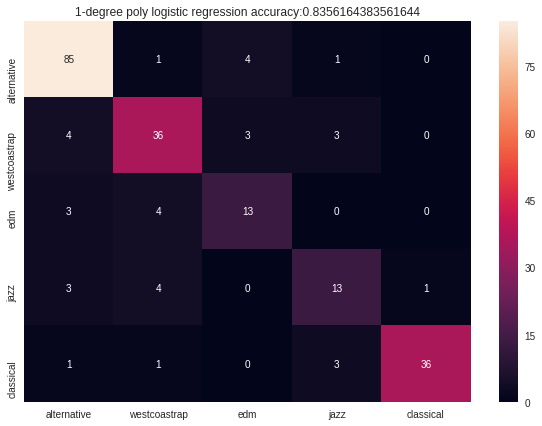

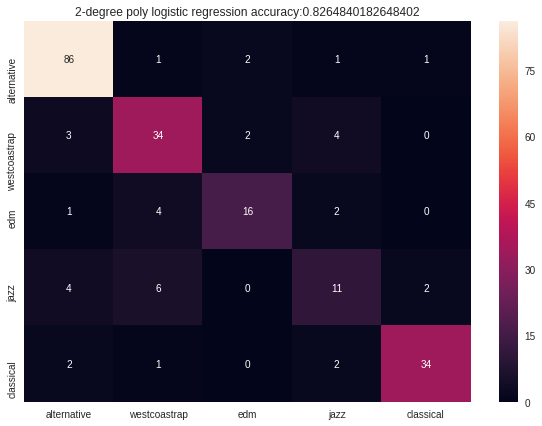

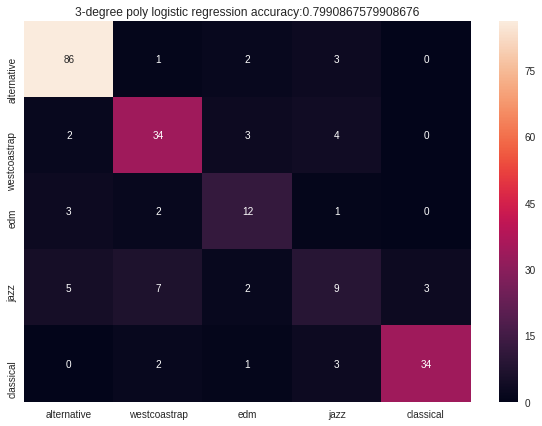

In [42]:
#logistic regression testing
for pval in range(1,4):
    model = linear_model.LogisticRegression()
    pf = PolynomialFeatures(degree = pval)
    pf.fit(X)
    yhat = cross_val_predict(model, pf.transform(X), Y, cv = StratifiedKFold(5,True))
    
    Titanic_Conf_matrix = confusion_matrix(yhat,Y)
    #print("{0}-degree poly logistic regression accuracy:{1}".format(pval, np.trace(Titanic_Conf_matrix)/np.sum(Titanic_Conf_matrix)))
    #print(Titanic_Conf_matrix)
    
    df_cm = pd.DataFrame(Titanic_Conf_matrix, index = [i for i in ['alternative', 'westcoastrap', 'edm', 'jazz', 'classical']],
                  columns = [i for i in ['alternative', 'westcoastrap', 'edm', 'jazz', 'classical']])
    plt.figure(figsize = (10,7))
    plt.title("{0}-degree poly logistic regression accuracy:{1}".format(pval, np.trace(Titanic_Conf_matrix)/np.sum(Titanic_Conf_matrix)))
    sn.heatmap(df_cm, annot=True)

<h2>Experimentation on percentage of each type each song was</h2>

As one of the main goals of this was to be able to predict the genre of a song given a database, we perform leave-one-out cross-validation with logistic regression on the values we have.

In [20]:
print('perc_alt', 'perc_classical', 'perc_edm', 'perc_jazz', 'perc_rap')
def abx(Z,x):
    return np.append(Z[:x],Z[x+1:],axis=0)
pf = PolynomialFeatures(degree=1)
pf.fit(X)
phi = pf.transform(X)
score = 0
for idx in range(np.shape(phi)[0]):
    
    model = linear_model.LogisticRegression()
    # To test things, we fit on everything else
    model.fit(abx(phi,idx),abx(Y,idx))
    predicted_scores = model.predict_proba(phi[idx:idx+1])[0]
    # normalize percentages
    perc_alt = "%.6f" % ((predicted_scores[0] / sum(predicted_scores)) * 100)
    perc_rap = "%.6f" % ((predicted_scores[1] / sum(predicted_scores)) * 100)
    perc_edm = "%.6f" % ((predicted_scores[2] / sum(predicted_scores)) * 100)
    perc_jazz = "%.6f" % ((predicted_scores[3] / sum(predicted_scores)) * 100)
    perc_classical = "%.6f" % ((predicted_scores[4] / sum(predicted_scores)) * 100)
    score += predicted_scores[Y[idx]]
    print(song_names[idx])
    print(perc_alt, '    ', perc_classical, '       ', perc_edm, '    ', perc_jazz, '    ', perc_rap)
#order: 'alt', 'classical', 'edm', 'jazz'
print("overall score: {0}".format(score/np.shape(X)[0]))

perc_alt perc_classical perc_edm perc_jazz perc_rap
Nujabes - Lady Brown.mp3
1.440736      0.000052         27.752163      68.776329      2.030720
Ice Cube - You Know How We Do It (Official Video).mp3
0.811481      0.006456         0.007188      95.448876      3.726000
Xzibit - X.mp3
5.855544      0.000000         0.000463      0.081459      94.062534
WC - The Streets ft. Snoop Dogg, Nate Dogg.mp3
0.000764      0.000001         1.411328      0.133985      98.453922
2Pac - Skandalouz.mp3
0.450177      0.000000         0.141004      0.037125      99.371694
Snoop Dogg - Midnight Love.mp3
2.147774      0.000000         1.291948      13.986231      82.574048
Dr. Dre - Forgot About Dre ft. Eminem, Hittman.mp3
5.859086      0.000000         0.079585      0.133835      93.927494
Kurupt - We Can Freak It.mp3
7.864905      0.015692         0.067325      19.779791      72.272286
Cyne - Midas.mp3
53.591864      0.000000         2.185376      22.883068      21.339692
The Dogg Pound - I Don't Like t

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

DJ Quik - Itz Your Fantasy.mp3
4.108069      0.000000         0.000286      0.432717      95.458927
2Pac - Happy Home (Nujabes Remix).mp3
1.089925      0.000909         15.803953      62.894440      20.210773
Gin and juice - Snoop Doggy Dogg.mp3
30.855900      0.000000         0.000002      0.000073      69.144026
Twinz - Eastside Lb.mp3
0.133783      0.000000         0.003807      0.592799      99.269611
The Game, 50 Cent - Hate It Or Love It (Official Music Video).mp3
0.392150      0.000000         0.085789      2.159056      97.363005
213 Groupie Luv.mp3
0.084328      0.000000         0.908705      0.091986      98.914981
Landon Wordswell - I think i need you now (prod by Kondor) - 2011 (Free Mixtape).mp3
0.053225      0.000000         50.165144      0.000438      49.781193
Ice Cube & Dr DRE - Natural Born Killaz.mp3
1.607263      0.000000         0.000015      0.535129      97.857593
South Central Cartel - All Day Everyday.mp3
0.070273      0.000000         0.000216      10.861738 

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

Snoop doggy dogg - aint no fun (if the homies cant get none).mp3
0.031534      0.000000         0.007939      0.495576      99.464951
Dr. Dre - Still D.R.E. ft. Snoop Dogg.mp3
0.003442      1.009131         2.767418      3.015809      93.204201
Ice Cube - It Was A Good Day (Official Video).mp3
0.004438      35.221300         0.000060      0.728259      64.045944
N.W.A. - Straight Outta Compton.mp3
8.771753      0.000000         0.000173      0.051241      91.176833
Snoop Doggy Dogg - Murder Was The Case ( Uncensored ).mp3
0.213012      0.000000         48.571662      0.000347      51.214979
Warren G - Regulate ft. Nate Dogg.mp3
0.008310      0.000000         1.317701      16.696077      81.977912
Ice Cube - Ghetto Bird (Music Video).mp3
0.287231      0.000000         1.437863      0.871090      97.403817
Compton's Most Wanted - Hood Took Me Under.mp3
0.014535      0.000000         0.023272      0.105375      99.856818
Dr. Dre - Let Me Ride.mp3
0.068207      0.000000         0.001734   

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

Uppermost - Beautiful Light.mp3
5.738920      0.275043         51.710939      1.223913      41.051185
born_mitiS.mp3
4.063417      0.000000         77.789521      5.987778      12.159284
shootingStars_bagRaiders.mp3
0.023165      0.000000         62.498498      15.737095      21.741243
AViVA - GRRRLS.mp3
0.335838      0.000000         86.980529      0.047185      12.636447
OceanBlue_WRLD.mp3
0.333779      0.000001         89.898109      0.161110      9.607002
TroyBoi - On My Own (feat. Nefera).mp3
0.000685      0.000003         0.594867      30.220195      69.184250
Crywolf - Eyes Half Closed.mp3
9.475065      0.000000         89.650424      0.011429      0.863082
Vanic X K.Flay - Cops.mp3
2.586684      0.000000         96.082397      0.922565      0.408354
Flume - Say It (feat. Tove Lo) (Illenium Remix).mp3
48.666785      0.000000         50.721549      0.558035      0.053631
Lauv - The Other (Official Lyric Video).mp3
6.819915      0.000106         2.784497      26.293575      64.101

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/py

Johann Sebastian Bach - Brandenburg Concerto No. 3 (Allegro-Adagio).mp3
0.002649      67.511147         0.000814      29.717461      2.767930
rachmaninov-prelude-in-c-sharp-minor-youtubemp3free.org.mp3
0.009268      98.684037         0.689567      0.603282      0.013846
Andrew Lyon conducts Faure - Pavane.mp3
0.002355      97.671735         0.432083      1.893819      0.000007
Vivaldi Concerto for 4 Violins in B minor RV 580.mp3
16.377694      82.215309         0.181799      0.737859      0.487339
Edvard Grieg Peer Gynt - Morning Mood.mp3
0.000011      87.256979         0.000224      10.161697      2.581088
Johann Sebastian Bach Gounod - Ave Maria - wedding music classical instrumental duet.mp3
49.409317      49.450825         1.092674      0.047185      0.000000
Spring. Antonio Vivaldi.mp3
0.334910      81.885649         0.000100      17.592504      0.186837
Franz Liszt Rjve D'Amour No. 3 in A Flat Major.mp3
0.000072      86.844204         1.171000      11.794424      0.190300
chopin-

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

P. Tchaikovsky - Pas de Deux ('The Nutcracker').mp3
0.554467      89.926261         0.108057      9.410723      0.000491
claude-debussy-clair-de-lune-youtubemp3free.org.mp3
0.000000      80.563632         1.235875      14.962706      3.237787
Dmitri Shostakovich Jazz Suite, Waltz No. 2.mp3
0.104422      90.936146         0.750314      8.204522      0.004596
Wagner - RIDE OF THE VALKYRIES - Furtwangler.mp3
0.017611      99.762710         0.009022      0.202250      0.008407
colorful-orchestra-rebellion-youtubemp3free.org.mp3
60.874311      0.703953         0.070740      38.339145      0.011850
Respighi - Ancient Dances and Airs - Suite 2 - mvt 4.mp3
0.001314      95.865163         0.169072      3.574963      0.389489
Rachmaninoff - Piano Concerto No. 2, Op. 18 I. Moderato (Rubinstein).mp3
0.018648      88.025794         10.593736      1.360086      0.001736
Camille Saint-Saëns - Aquarium.mp3
0.001086      99.717015         0.243115      0.038783      0.000002
Cyril Smith plays Rachmanin

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

johann-sebastian-bachair-on-g-string-youtubemp3free.org.mp3
1.442887      97.169232         0.026835      1.295719      0.065326
Beethoven-Fur Elise.mp3
0.006796      99.004077         0.983329      0.004503      0.001295
Hiroshi Suzuki-Romance.mp3
0.029518      0.000394         0.263534      80.037510      19.669044
BART HOWARD (fly me to the moon).mp3
3.546134      54.448884         0.002824      42.001185      0.000973
Miles Davis - Milestones (Audio).mp3
0.013081      0.001062         0.692855      31.646697      67.646306
Summertime George Gershwin 1935 Tenor Sax.mp3
3.016135      0.000003         0.126942      70.913590      25.943330
Blue in Green by. Miles Davis.mp3
0.010985      2.536080         0.003579      1.535677      95.913678
Jazz Piano Beegie Adair - Moon River ( Henry Mancini - Johnny Mercer ).mp3
0.172230      0.003822         64.152107      24.973614      10.698227
John Cameron - Liquid Sunshine - 1973 [Library Music].mp3
9.355267      0.213565         27.026978    

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

Duke Ellington and his orchestra.- Satin Doll (HD).mp3
36.797717      27.822405         0.262532      35.117240      0.000106
Cowboy Bebop OST 1 - Rush.mp3
99.260279      0.060562         0.677499      0.000838      0.000823
Jiro Inagaki & Soul Media - Breeze - 1974.mp3
41.157580      0.001829         4.233626      54.552396      0.054568
東方 Piano JazzSatellite Café Terrace #4- tanigon.mp3
43.123554      0.000849         2.086006      54.718445      0.071145
Bill Evans - The Two Lonely People.mp3
0.195887      0.108471         0.090038      73.328858      26.276746
104 First Day of My Life.m4a
99.605012      0.000001         0.078090      0.308814      0.008083
Silversun Pickups - Lazy Eye (Official Video).mp3
52.303631      0.000018         27.643387      20.052575      0.000389
05 80's Comedown Machine.m4a
99.750015      0.000000         0.011546      0.238190      0.000249
09 Infinity.m4a
99.423348      0.000000         0.073590      0.489262      0.013800
01 Everything In Its Right

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

06 Bavarian #1 (Say You Will).m4a
58.543801      0.000000         0.112122      36.170868      5.173209
SicTransitGloria_BrandNew.mp3
0.668131      0.000000         46.149605      0.027191      53.155073
Coheed and Cambria Neverender.mp3
92.279637      0.000000         0.000392      6.001952      1.718019
06 50_50.m4a
99.995222      0.000000         0.000175      0.004603      0.000000
05 All I Need.m4a
96.758191      0.000000         1.516469      1.725067      0.000273
03 Subterranean Homesick Alien.m4a
96.994711      0.000000         0.103175      2.900958      0.001155
07 Last Nite.m4a
99.995915      0.000000         0.000234      0.003851      0.000000
04 Trying to Be Cool.m4a
99.187331      0.000000         0.579852      0.232718      0.000098
03 One Way Trigger.m4a
99.996431      0.000000         0.001066      0.002405      0.000098
09 Bourgeois.m4a
90.144537      0.000000         7.555378      2.299411      0.000674
12 Manna (Demo).m4a
99.990470      0.006744         0.000760  

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

     0.004772      0.001971
03 Nude.m4a
99.667458      0.000000         0.106420      0.226115      0.000008
Goo Goo Dolls - Slide [Official Music Video].mp3
97.778582      0.002078         1.032794      1.184653      0.001893
08 Electioneering.m4a
99.957206      0.000000         0.010376      0.032339      0.000079
Smashing Pumpkins - Mayonaise.mp3
49.232512      0.000096         0.000077      3.578544      47.188771
11 Untitled.m4a
0.000076      0.395740         92.123823      7.480361      0.000001
08 Partners In Crime.m4a
99.921948      0.000000         0.001950      0.076101      0.000001
02 All the Time.m4a
99.023738      0.000000         0.013877      0.961844      0.000542
07 Slow Animals.m4a
99.270582      0.000000         0.001533      0.727736      0.000149
07 Shelter.m4a
77.122215      0.000001         0.000209      22.877424      0.000152
04 My Mathematical Mind.m4a
95.753919      0.000000         4.196161      0.046759      0.003161
Gin Blossoms - Hey Jealousy.mp3
74.5782

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

07 Father.m4a
92.594465      0.000000         4.070422      3.258682      0.076431
05 Fluorescent Adolescent.m4a
99.914799      0.000000         0.040395      0.007977      0.036828
Red Hot Chili Peppers - Otherside [Official Music Video].mp3
25.674197      0.000000         0.086079      0.847167      73.392557
02 Piggy.m4a
95.451743      0.000000         0.000155      0.000297      4.547805
01 Islands.m4a
77.511236      0.000000         0.001701      22.281656      0.205407
Rise Against - Savior (Official Video).mp3
0.005178      0.000000         90.186902      0.016398      9.791521
05 Heart Skipped a Beat.m4a
70.840131      0.000000         0.001944      9.445513      19.712412
01 Mr. Self Destruct.m4a
97.778062      0.000000         2.215156      0.000968      0.005813
07 Elk.m4a
99.968019      0.005783         0.000025      0.026173      0.000000
13 Go.m4a
99.915089      0.000000         0.019330      0.065504      0.000076
05 Treefingers.m4a
50.801892      0.000000         0.1387

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

09 If You Were There, Beware.m4a
99.877140      0.000000         0.002165      0.117106      0.003590
09 Was It You_.m4a
99.157780      0.000000         0.000441      0.023147      0.818631
Red Hot Chili Peppers - Dark Necessities [OFFICIAL VIDEO].mp3
33.849326      0.000001         34.974528      31.129894      0.046252
04 Barely Legal.m4a
98.881515      0.000000         0.000075      1.118368      0.000042
03 Crystalised.m4a
93.272196      0.000007         5.853593      0.873406      0.000798
03 In the Aeroplane Over the Sea.m4a
99.937385      0.000000         0.014608      0.047988      0.000019
01 Entertainment.m4a
99.767340      0.000000         0.020658      0.211454      0.000548
10 Happy Ending.m4a
99.958812      0.000000         0.001637      0.039475      0.000076
07 Empty Party Rooms.m4a
99.784523      0.000000         0.061876      0.153017      0.000584
07 Do Me a Favour.m4a
99.609318      0.000000         0.001828      0.171444      0.217410
05 Bankrupt!.m4a
90.662501    

/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py

09 Chances.m4a
97.478126      0.000000         0.007078      2.510248      0.004547
11 Colly Strings.m4a
99.928477      0.000000         0.027609      0.032827      0.011087
02 The Two Sides of Monsieur Valenti.m4a
99.779556      0.000000         0.129440      0.089980      0.001025
06 Drakkar Noir.m4a
99.965647      0.000000         0.032973      0.001275      0.000105
Oasis - Wonderwall (Official Video).mp3
62.150309      0.001732         0.024348      28.115643      9.707969
01 Wide Eyes.m4a
97.594703      0.000000         0.002534      2.081003      0.321760
02 Airplanes.m4a
95.695538      0.000003         0.698911      3.603185      0.002363
11 Legit Tattoo Gun.m4a
99.725537      0.000000         0.041460      0.232154      0.000849
03 D Is for Dangerous.m4a
99.997366      0.000000         0.001938      0.000393      0.000303
08 Archipelago.m4a
89.615701      0.000000         0.442689      8.532124      1.409486
overall score: 0.7621335117387228


/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ben/music_classifier/venv/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/ben/music_classifier/venv/lib/py